In [561]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [106]:
import pandas as pd
import numpy as np
import os
import sys
import copy
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind, pearsonr
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as hierarchy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
size = lambda obj: '%s MB' % np.round(sys.getsizeof(obj) / (1024**2), 1)

In [160]:
from preparation_functions import *
from method_functions import *
from plot_functions import *
from general_functions import *

In [5]:
projectDir = 'c:/Projects/A_PDX_drug_synergy/'
dirAZpharmacol = projectDir + 'data/restricted_use/syn18496666/AZ Drug Synergy Data/'
dirAZmolecular = projectDir + 'data/restricted_use/syn4923181/'
dirGDSCsensitivity = projectDir + 'data/fromGDSC/'
dirGraceCuratedSynergy = projectDir + 'data/curated synergy Grace/'
dirFromSanger = projectDir + 'data/fromSanger/' # https://cellmodelpassports.sanger.ac.uk/downloads

# Sensitivity

In [6]:
#               LNIC50         H       EINF
# MODEL DRUG                               
# 22RV1 AKT  -1.128191  4.117612  65.593002
#       AR    0.551742  0.234400  88.396987
#       AR_1  1.544170  2.815893  42.790641

In [7]:
df_drug_sensitivity_AZ = prepAZsensitivity(dirAZpharmacol + 'Combined Challenge Synergy Data/')
print(df_drug_sensitivity_AZ.shape)

(4861, 3)


In [8]:
df_drug_sensitivity_GDSC1 = prepGDSC('GDSC1', dirGDSCsensitivity)
print(df_drug_sensitivity_GDSC1.shape)

(292849, 2)


In [9]:
df_drug_sensitivity_GDSC2 = prepGDSC('GDSC2', dirGDSCsensitivity)
print(df_drug_sensitivity_GDSC2.shape)

(131108, 2)


In [10]:
df_drug_sensitivity_GDSC = pd.concat([df_drug_sensitivity_GDSC1, df_drug_sensitivity_GDSC2], axis=0).groupby(level=[0, 1]).mean()
print(df_drug_sensitivity_GDSC.shape)

(376632, 2)


# Synergy

In [11]:
# MODEL  DRUG1  DRUG2
# 22RV1  akt    ar        0.190
#               ar_1      6.415
#               bcl2    -54.700

In [12]:
# 119 drugs * 137 models = 19623 unique pairs
se_drug_synergy_AZ = prepAZsynergy(dirAZpharmacol + 'Combined Challenge Synergy Data/')
print(se_drug_synergy_AZ.shape)

(39246,)


In [13]:
# 240 drugs * 109 models = 437 unique pairs
se_drug_synergy_Narayan = prepNarayanSynergy(dirGraceCuratedSynergy + 'edited_41467_2020_16735_MOESM5_ESM.xlsx')
print(se_drug_synergy_Narayan.shape)

(874,)


# DREAM challenge index

In [489]:
se_AZchallengeIndex = loadAZchallengeIndex(se_drug_synergy_AZ, dirAZpharmacol)

4273 c:/Projects/A_PDX_drug_synergy/data/restricted_use/syn18496666/AZ Drug Synergy Data/ch1_train_combination_and_monotherapy.csv
2178 c:/Projects/A_PDX_drug_synergy/data/restricted_use/syn18496666/AZ Drug Synergy Data/ch1_test_monotherapy.csv
1182 c:/Projects/A_PDX_drug_synergy/data/restricted_use/syn18496666/AZ Drug Synergy Data/ch1_lb.csv
7643 c:/Projects/A_PDX_drug_synergy/data/restricted_use/syn18496666/AZ Drug Synergy Data/ch2_test_monotherapy.csv
7740 c:/Projects/A_PDX_drug_synergy/data/restricted_use/syn18496666/AZ Drug Synergy Data/ch2_lb.csv
22634
ch2_leaderboard    7556
ch2_test           7534
ch1_train          4224
ch1_test           2154
ch1_leaderboard    1166
Name: SYNERGY_SCORE, dtype: int64


In [15]:
# Test ro
subset = se_drug_synergy_AZ.iloc[:10000].to_frame()
subset['SYNERGY_SCORE_PREDICTED'] = np.random.rand(len(subset))
print(ro_normalized(subset))

-0.015930937505067508


# Tissue annotation

In [16]:
# MODEL
# 1181N1     Central Nervous System
# 1205Lu                       Skin
# 1273-99               Soft Tissue

In [17]:
se_tissue_annotation_GDSC = getTissueAnnotationGDSC(dirFromSanger + 'model_list_20210719.csv')
print(se_tissue_annotation_GDSC.value_counts().to_dict())
print(se_tissue_annotation_GDSC.shape)

{'Haematopoietic and Lymphoid': 370, 'Lung': 293, 'Skin': 131, 'Large Intestine': 123, 'Central Nervous System': 118, 'Head and Neck': 95, 'Ovary': 85, 'Breast': 82, 'Bone': 82, 'Esophagus': 74, 'Pancreas': 74, 'Soft Tissue': 73, 'Kidney': 63, 'Peripheral Nervous System': 48, 'Stomach': 46, 'Bladder': 40, 'Biliary Tract': 39, 'Cervix': 32, 'Endometrium': 30, 'Liver': 29, 'Thyroid': 21, 'Prostate': 15, 'Eye': 11, 'Uterus': 8, 'Unknown': 7, 'Testis': 5, 'Placenta': 4, 'Vulva': 3, 'Small Intestine': 2, 'Adrenal Gland': 1}
(2004,)


In [18]:
se_tissue_annotation_AZ = getTissueAnnotationAZ(dirAZmolecular + 'cell_info.csv.gz')
print(se_tissue_annotation_AZ.value_counts().to_dict())
print(se_tissue_annotation_AZ.shape)

{'breast': 34, 'lung': 22, 'urinary tract': 12, 'gastrointestinal tract (lower)': 10, 'soft tissue': 2, 'gastrointestinal tract (upper)': 2, 'male genital system': 2, 'blood/lymph': 1}
(85,)


# Models mutations

In [19]:
# MODEL
# 22RV1    [A1CF, A1CF_ENST00000282641, A1CF_ENST00000373...
# 647-V    [A2ML1, AASDH, AASDH_ENST00000502617, AASS, AB...
# A549     [AATK, AATK_ENST00000326724, ABCA9, ABCB1, ABC...

In [20]:
se_models_mutations_AZ = prepMutationsAZ(dirAZmolecular + 'mutations.csv.gz')
print(se_models_mutations_AZ.shape)

(85,)


In [21]:
se_models_mutations_GDSC = prepMutationsGDSC(dirFromSanger + 'mutations_20191101.csv')
print(se_models_mutations_GDSC.shape)

(1032,)


# Drug targets

In [22]:
# DRUG
# (5Z)-7-Oxozeaenol                        [MAP3K7]
# 5-Fluorouracil       [Antimetabolite (DNA & RNA)]
# A-443654                       [AKT1, AKT2, AKT3]

In [23]:
se_drug_targets_GDSC = prepDrugTargetsGDSC(dirGraceCuratedSynergy + 'screened_compunds_updated.xlsx')  # 442 drugs
print(se_drug_targets_GDSC.apply(len).value_counts().sort_index().to_dict())
print(se_drug_targets_GDSC.shape)

{1: 245, 2: 91, 3: 48, 4: 16, 5: 9, 6: 5, 7: 8, 8: 3, 9: 1, 10: 2, 11: 5, 12: 2, 14: 1, 16: 1, 18: 2, 23: 1, 31: 1, 39: 1}
(442,)


In [24]:
se_drug_targets_AZ = prepDrugTargetsAZ(dirAZpharmacol + 'drug_info_release.csv.gz', dirFromSanger + 'gene_identifiers_20191101.csv')
print(se_drug_targets_AZ.apply(len).value_counts().sort_index().to_dict())
print(se_drug_targets_AZ.shape)

{1: 68, 2: 19, 3: 13, 4: 6, 5: 1, 6: 1, 7: 2, 8: 3, 9: 2, 12: 2, 15: 1, 21: 1}
(119,)


# Prepare values for regression or classifier

In [26]:
dataset = 'AZ'

if dataset=='GDSC1':
    se_drug_synergy = se_drug_synergy_Narayan
    se_tissue_annotation = se_tissue_annotation_GDSC
    df_drug_sensitivity = df_drug_sensitivity_GDSC1
    se_models_mutations = se_models_mutations_GDSC
    se_drug_targets = se_drug_targets_GDSC
    tissue = 'Breast' # None or: ['Breast' 'Bladder']'
    synergy_cutoff = 1.
elif dataset=='GDSC2':
    se_drug_synergy = se_drug_synergy_Narayan
    se_tissue_annotation = se_tissue_annotation_GDSC
    df_drug_sensitivity = df_drug_sensitivity_GDSC2
    se_models_mutations = se_models_mutations_GDSC
    se_drug_targets = se_drug_targets_GDSC
    tissue = 'Breast' # None or: ['Breast' 'Bladder']
    synergy_cutoff = 1.
elif dataset=='GDSC':
    se_drug_synergy = se_drug_synergy_Narayan
    se_tissue_annotation = se_tissue_annotation_GDSC
    df_drug_sensitivity = df_drug_sensitivity_GDSC
    se_models_mutations = se_models_mutations_GDSC
    se_drug_targets = se_drug_targets_GDSC
    tissue = 'Breast' # None or: ['Breast' 'Bladder']
    synergy_cutoff = 1.
elif dataset=='AZ':
    se_drug_synergy = se_drug_synergy_AZ
    se_tissue_annotation = se_tissue_annotation_AZ
    df_drug_sensitivity = df_drug_sensitivity_AZ
    se_models_mutations = se_models_mutations_AZ
    se_drug_targets = se_drug_targets_AZ
    tissue = 'breast' # None or: 
    # ['breast', 'lung', 'urinary tract', gastrointestinal tract (lower)', 
    # 'gastrointestinal tract (upper)', 'male genital system', 'soft tissue', 'blood/lymph']
    synergy_cutoff = 20.
    
dfC, dfS, Z = getDistanceAndSensitivityData(df_drug_sensitivity, method='cosine')
dfTa = prepDfTa(df_drug_sensitivity, se_models_mutations, se_drug_targets, dataset)
dfTas = prepDfTas(dfTa, se_drug_synergy, se_tissue_annotation, tissue=tissue)

dfTas['Cij'] = dfC.stack().reindex(pd.MultiIndex.from_frame(dfTas.index.to_frame()[['DRUG1', 'DRUG2']])).values
dfTas['Sik'] = dfS.stack().reindex(pd.MultiIndex.from_frame(dfTas.index.to_frame()[['MODEL', 'DRUG1']])).values
dfTas['Sjk'] = dfS.stack().reindex(pd.MultiIndex.from_frame(dfTas.index.to_frame()[['MODEL', 'DRUG2']])).values

C:\Projects\A_PDX_drug_synergy\VS\DrugSynergyPrediction\method_functions.py:18: RuntimeWarning: invalid value encountered in double_scalars
  return (u[wh] * v[wh]).sum() / np.sqrt((u[wh] * u[wh]).sum() * (v[wh] * v[wh]).sum())


Loading from cache...
85 cell lines, 13924 drug pairs
Synergy pairs in:	 39246
Synergy pairs out:	 26020
Data size: 1183540
0 
With known synergy: 14742
With unknown synergy: 458674


In [27]:
dfTas_copy = dfTas.copy()
seed = 0

if not dataset=='AZ':
    dfTas_copy.loc[dfTas_copy[dfTas_copy['SYNERGY_SCORE'].isna()].sample(100, random_state=seed).index, 'SYNERGY_SCORE'] = 0.

df_train_test, df_validate, df_predict = split_train_test_validate_predict(dfTas_copy, factor=2/3, random_state=seed)


All pairs:		 473416
Pairs with missing:	 418367
All with known pairs:	 14742
Training-testing pairs:	 9828
Validation pairs:	 4914
Prediction pairs:	 40307


In [493]:
dfTas_copy[(~dfTas_copy['Cij'].isna()) & (~dfTas_copy['Sik'].isna()) & (~dfTas_copy['Sjk'].isna())].reset_index('TISSUE')['SYNERGY_SCORE'].isna().value_counts()

True     40307
False    14742
Name: SYNERGY_SCORE, dtype: int64

In [498]:
breast_CLs = se_tissue_annotation_AZ[se_tissue_annotation_AZ=='breast'].index

In [499]:
se_AZchallengeIndex_breast_CLs = se_AZchallengeIndex.loc[se_AZchallengeIndex.index.get_level_values('MODEL').isin(breast_CLs)]
se_AZchallengeIndex_breast_CLs.value_counts()

ch2_test           4450
ch2_leaderboard    4280
ch1_train          2260
ch1_test           1210
ch1_leaderboard     664
Name: SYNERGY_SCORE, dtype: int64

In [524]:
def prepCh1(df, index_train_test, index_validate):
    
    df_temp = df.loc[(~df['Cij'].isna()) & (~df['Sik'].isna()) & (~df['Sjk'].isna()) & (~df['SYNERGY_SCORE'].isna())]
    print('All with known pairs:\t', df_temp.shape[0])
    
    df_train_test = df_temp.loc[df_temp.reset_index('TISSUE').index.isin(index_train_test)]
    print('Training-testing pairs:\t', df_train_test.shape[0])
    
    df_validate = df_temp.loc[df_temp.reset_index('TISSUE').index.isin(index_validate)]
    print('Validation pairs:\t', df_validate.shape[0])

    return df_train_test, df_validate

df_train_test_ch1, df_validate_ch1 = prepCh1(dfTas_copy,
                                             se_AZchallengeIndex_breast_CLs[se_AZchallengeIndex_breast_CLs=='ch1_train'].index,
                                             se_AZchallengeIndex_breast_CLs[se_AZchallengeIndex_breast_CLs=='ch1_test'].index)

All with known pairs:	 14742
Training-testing pairs:	 2260
Validation pairs:	 1210


### Regression model per tissue
Learn about synergy for the different drug pairs in different cell lines of a selected tissue.<br>
Transter this knowledge to predict synergy for a new cell line and another drug pair (of the same tissue!).<br>
$logit(\Theta_{ijk}) = a_1 + a_2*T_{ijk} + a_3*C_{ij} + a_4*S_{ik} + a_5*S_{jk}$<br>
<br>
Need to explore goodness of fit (Chi-square goodness of fit tests and deviance) with and without some of the terms.
As compared to random?

Cell line tissue: seTissues <br>
Target information: dfTa_k(ij) = dfT_ki | dfT_kj <br>
Cophenetic distance: dfC_ij <br>
Sensitivity to drug i: dfS_ki <br>
Sensitivity to drug j: dfS_kj <br>
Known synergy between drugs i and j: dfKS_(ij)

In [311]:
# df_sub = df_validate.copy()[['SYNERGY_SCORE']].droplevel('TISSUE')
# df_sub['SYNERGY_SCORE'] = df_validate['SYNERGY_SCORE'].values
# df_sub['Predicted'] = r #+ 0.1*np.random.rand(len(r))
# print(ro_normalized(df_sub))
# # df_sub['SYNERGY_SCORE'][df_sub['SYNERGY_SCORE'].abs()<200].hist(bins=100, alpha=0.5)
# # df_sub['Predicted'][df_sub['Predicted'].abs()<200].hist(bins=100, alpha=0.5)
# # df_sub

In [559]:
def fit_validate_predict(inData, inSynergy, extData=None, extSynergy=None, cv=None, max_iter=10**4, scoring=['f1_macro', 'roc_auc', 'accuracy']):

    # clf = LogisticRegression(max_iter=max_iter, random_state=0)
    # clf = DecisionTreeClassifier(random_state=0, max_depth=40)
    # clf = RandomForestClassifier(random_state=0, max_depth=40, n_estimators=100)
    clf = RandomForestRegressor(random_state=0, max_depth=40, n_estimators=250)
    
    clf.fit(inData, inSynergy)
    print('On self:\t\t', np.round(pearsonr(inSynergy, clf.predict(inData))[0], 5))
    
    def getPartitions(df, se, n_splits=4, shuffle=True, seed=None):
        np.random.seed(seed)
        df_ = pd.concat([df, se], axis=1)
        splitter = KFold(n_splits=n_splits, shuffle=shuffle)
        sp = [(df_.T.iloc[:, i].values, df_.T.iloc[:, j].values) for (i, j) in list(splitter.split(df_))]
        return [((u[:-1, :], v[:-1, :]), (u[-1:, :], v[-1:, :])) for u, v in sp]
    
    partitions = getPartitions(pd.DataFrame(inData), pd.Series(inSynergy), n_splits=cv, shuffle=True, seed=41) 
    
    scores = []
    for ((df_train, df_test), (se_train, se_test)) in partitions:
        clf.fit(df_train.T, se_train[0])
        
        predicted = clf.predict(df_test.T)
        score = np.round(pearsonr(se_test[0], predicted)[0], 5)
        
        # score = np.round(f1_score(se_test[0], predicted), 5)
        scores.append(score)
        
    print('Cross-validation:\t', scores)
    
    if (not extData is None) and (not extSynergy is None):
        print('Validation data:\t', np.round(pearsonr(extSynergy, clf.predict(extData))[0], 5))
        return clf.predict(extData)
    
    return clf

In [545]:
df_train_test_ch1.index.get_level_values('MODEL').unique().sort_values().values # includes 'MDA-MB-175-VII'
# df_train_test_ch1.index.get_level_values('DRUG1').unique().sort_values().values # inclusdes 'tnf', 'wnt'

['BT-20', 'BT-474', 'BT-549', 'CAL-120', 'CAL-148', ..., 'MDA-MB-453', 'MDA-MB-468', 'MFM-223', 'T47D', 'UACC-812']
Length: 34
Categories (34, object): ['BT-20', 'BT-474', 'BT-549', 'CAL-120', ..., 'MDA-MB-468', 'MFM-223', 'T47D', 'UACC-812']

In [546]:
df_validate_ch1.index.get_level_values('MODEL').unique().sort_values().values
# df_validate_ch1.index.get_level_values('DRUG1').unique().sort_values().values

['BT-20', 'BT-474', 'BT-549', 'CAL-120', 'CAL-148', ..., 'MDA-MB-453', 'MDA-MB-468', 'MFM-223', 'T47D', 'UACC-812']
Length: 33
Categories (33, object): ['BT-20', 'BT-474', 'BT-549', 'CAL-120', ..., 'MDA-MB-468', 'MFM-223', 'T47D', 'UACC-812']

In [548]:
df_validate_ch1.index.get_level_values('DRUG1').unique().sort_values().values.shape

(40,)

In [560]:
dfe_train = encodeNames(df_train_test_ch1)
dfe_train = dfe_train[dfe_train.columns.intersection(encodeNames(df_validate_ch1).columns)]
dfe_validate = encodeNames(df_validate_ch1).reindex(dfe_train.columns, axis=1).fillna(0.).astype(int)

r = fit_validate_predict(dfe_train.values, 
                     df_train_test_ch1['SYNERGY_SCORE'].values,
                     extData=dfe_validate.values, 
                     extSynergy=df_validate_ch1['SYNERGY_SCORE'].values,
                     cv=4, scoring=['f1_macro'])

# r = fit_validate_predict(dfe_train.values, 
#                      (df_train_test_ch1['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values,
#                      extData=dfe_validate.values, 
#                      extSynergy=(df_validate_ch1['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values,
#                      cv=4, scoring=['f1_macro'])

On self:		 0.99438
Cross-validation:	 [0.91179, 0.90968, 0.86342, 0.86099]
Validation data:	 0.28056


In [526]:
dfe_train = encodeNames(df_train_test)
dfe_train = dfe_train[dfe_train.columns.intersection(encodeNames(df_validate).columns)]
dfe_validate = encodeNames(df_validate).reindex(dfe_train.columns, axis=1).fillna(0.).astype(int)

r = fit_validate_predict(dfe_train.values, 
                     df_train_test['SYNERGY_SCORE'].values,
                     extData=dfe_validate.values, 
                     extSynergy=df_validate['SYNERGY_SCORE'].values,
                     cv=4, scoring=['f1_macro'])

# r = fit_validate_predict(dfe_train.values, 
#                      (df_train_test['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values,
#                      extData=dfe_validate.values, 
#                      extSynergy=(df_validate['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values,
#                      cv=4, scoring=['f1_macro'])

On self:		 0.96388
Cross-validation:	 [0.53607, 0.71578, 0.67217, 0.71283]
Validation data:	 0.73643


In [324]:
# On self:		 0.96388
# Cross-validation:	 [0.53607, 0.71578, 0.67217, 0.71283]
# Validation data:	 0.73643

In [564]:
L = ['Tijk', 'Cij', 'Sik', 'Sjk']

# r = fit_validate_predict(df_train_test[L].values, 
#                      df_train_test['SYNERGY_SCORE'].values,
#                      extData=df_validate[L].values, 
#                      extSynergy=df_validate['SYNERGY_SCORE'].values,
#                      cv=4, scoring=['f1_macro'])

r = fit_validate_predict(df_train_test[L].values, 
                     (df_train_test['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values,
                     extData=df_validate[L].values, 
                     extSynergy=(df_validate['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values,
                     cv=4, scoring=['f1_macro'])

On self:		 0.88426
Cross-validation:	 [0.24438, 0.23259, 0.25005, 0.22574]
Validation data:	 0.25405


In [563]:
def fit_validate_predict_LR(inData, inSynergy, extData=None, extSynergy=None, cv=None, max_iter=10**4, scoring=['f1_macro', 'roc_auc', 'accuracy']):

    clf = LogisticRegression(max_iter=max_iter, random_state=0)
    # clf = DecisionTreeClassifier(random_state=0, max_depth=40)
    # clf = RandomForestClassifier(random_state=0, max_depth=40, n_estimators=100)
    # clf = RandomForestRegressor(random_state=0, max_depth=40, n_estimators=250)
    
    clf.fit(inData, inSynergy)
    print('On self:\t\t', np.round(pearsonr(inSynergy, clf.predict(inData))[0], 5))
    
    def getPartitions(df, se, n_splits=4, shuffle=True, seed=None):
        np.random.seed(seed)
        df_ = pd.concat([df, se], axis=1)
        splitter = KFold(n_splits=n_splits, shuffle=shuffle)
        sp = [(df_.T.iloc[:, i].values, df_.T.iloc[:, j].values) for (i, j) in list(splitter.split(df_))]
        return [((u[:-1, :], v[:-1, :]), (u[-1:, :], v[-1:, :])) for u, v in sp]
    
    partitions = getPartitions(pd.DataFrame(inData), pd.Series(inSynergy), n_splits=cv, shuffle=True, seed=41) 
    
    scores = []
    for ((df_train, df_test), (se_train, se_test)) in partitions:
        clf.fit(df_train.T, se_train[0])
        
        predicted = clf.predict(df_test.T)
        score = np.round(pearsonr(se_test[0], predicted)[0], 5)
        
        # score = np.round(f1_score(se_test[0], predicted), 5)
        scores.append(score)
        
    print('Cross-validation:\t', scores)
    
    if (not extData is None) and (not extSynergy is None):
        print('Validation data:\t', np.round(pearsonr(extSynergy, clf.predict(extData))[0], 5))
        return clf.predict(extData)
    
    return clf

L = ['Tijk', 'Cij', 'Sik', 'Sjk']

# r = fit_validate_predict(df_train_test[L].values, 
#                      df_train_test['SYNERGY_SCORE'].values,
#                      extData=df_validate[L].values, 
#                      extSynergy=df_validate['SYNERGY_SCORE'].values,
#                      cv=4, scoring=['f1_macro'])

r = fit_validate_predict_LR(df_train_test[L].values, 
                     (df_train_test['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values,
                     extData=df_validate[L].values, 
                     extSynergy=(df_validate['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values,
                     cv=4, scoring=['f1_macro'])

On self:		 0.05148


ValueError: Unknown label type: 'unknown'

### Run RandomizedSearchCV

In [124]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

clf = RandomForestClassifier(random_state=0, max_depth=20, n_estimators=300)
rf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

index = df_train_test.index
inSynergy = (df_train_test.loc[index]['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values
inData = df_train_test.loc[index][L].astype(float).copy()

rf_random.fit(inData, inSynergy)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=20,
                                                    n_estimators=300,
                                                    random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]}

### Evaluate RandomSearchCV findings

In [129]:
inSynergyV = (df_validate['SYNERGY_SCORE']>=synergy_cutoff).astype(float).values
inDataV = df_validate[L].astype(float).copy()

In [151]:
def evaluate(model, test_features, test_labels):
    accuracy = accuracy_score(test_labels, model.predict(test_features))
    f1score = f1_score(test_labels, model.predict(test_features))
    print('Accuracy = {:0.2f}%.'.format(100 * accuracy))
    print('F1 score = {:0.2f}%.'.format(100 * f1score))
    return accuracy

base_model = RandomForestClassifier(n_estimators=500, random_state=42)
base_model.fit(inData, inSynergy)
base_accuracy = evaluate(base_model, inDataV, inSynergyV)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, inDataV, inSynergyV)
print('Improvement of {:0.2f}%.'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Accuracy = 77.76%.
F1 score = 32.15%.
Accuracy = 79.57%.
F1 score = 16.47%.
Improvement of 2.33%.


### Run GridSearchCV

In [148]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [750, 1000]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(inData, inSynergy)
grid_search.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 750}

In [153]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, inDataV, inSynergyV)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Accuracy = 79.57%.
F1 score = 16.33%.
Improvement of 2.33%.


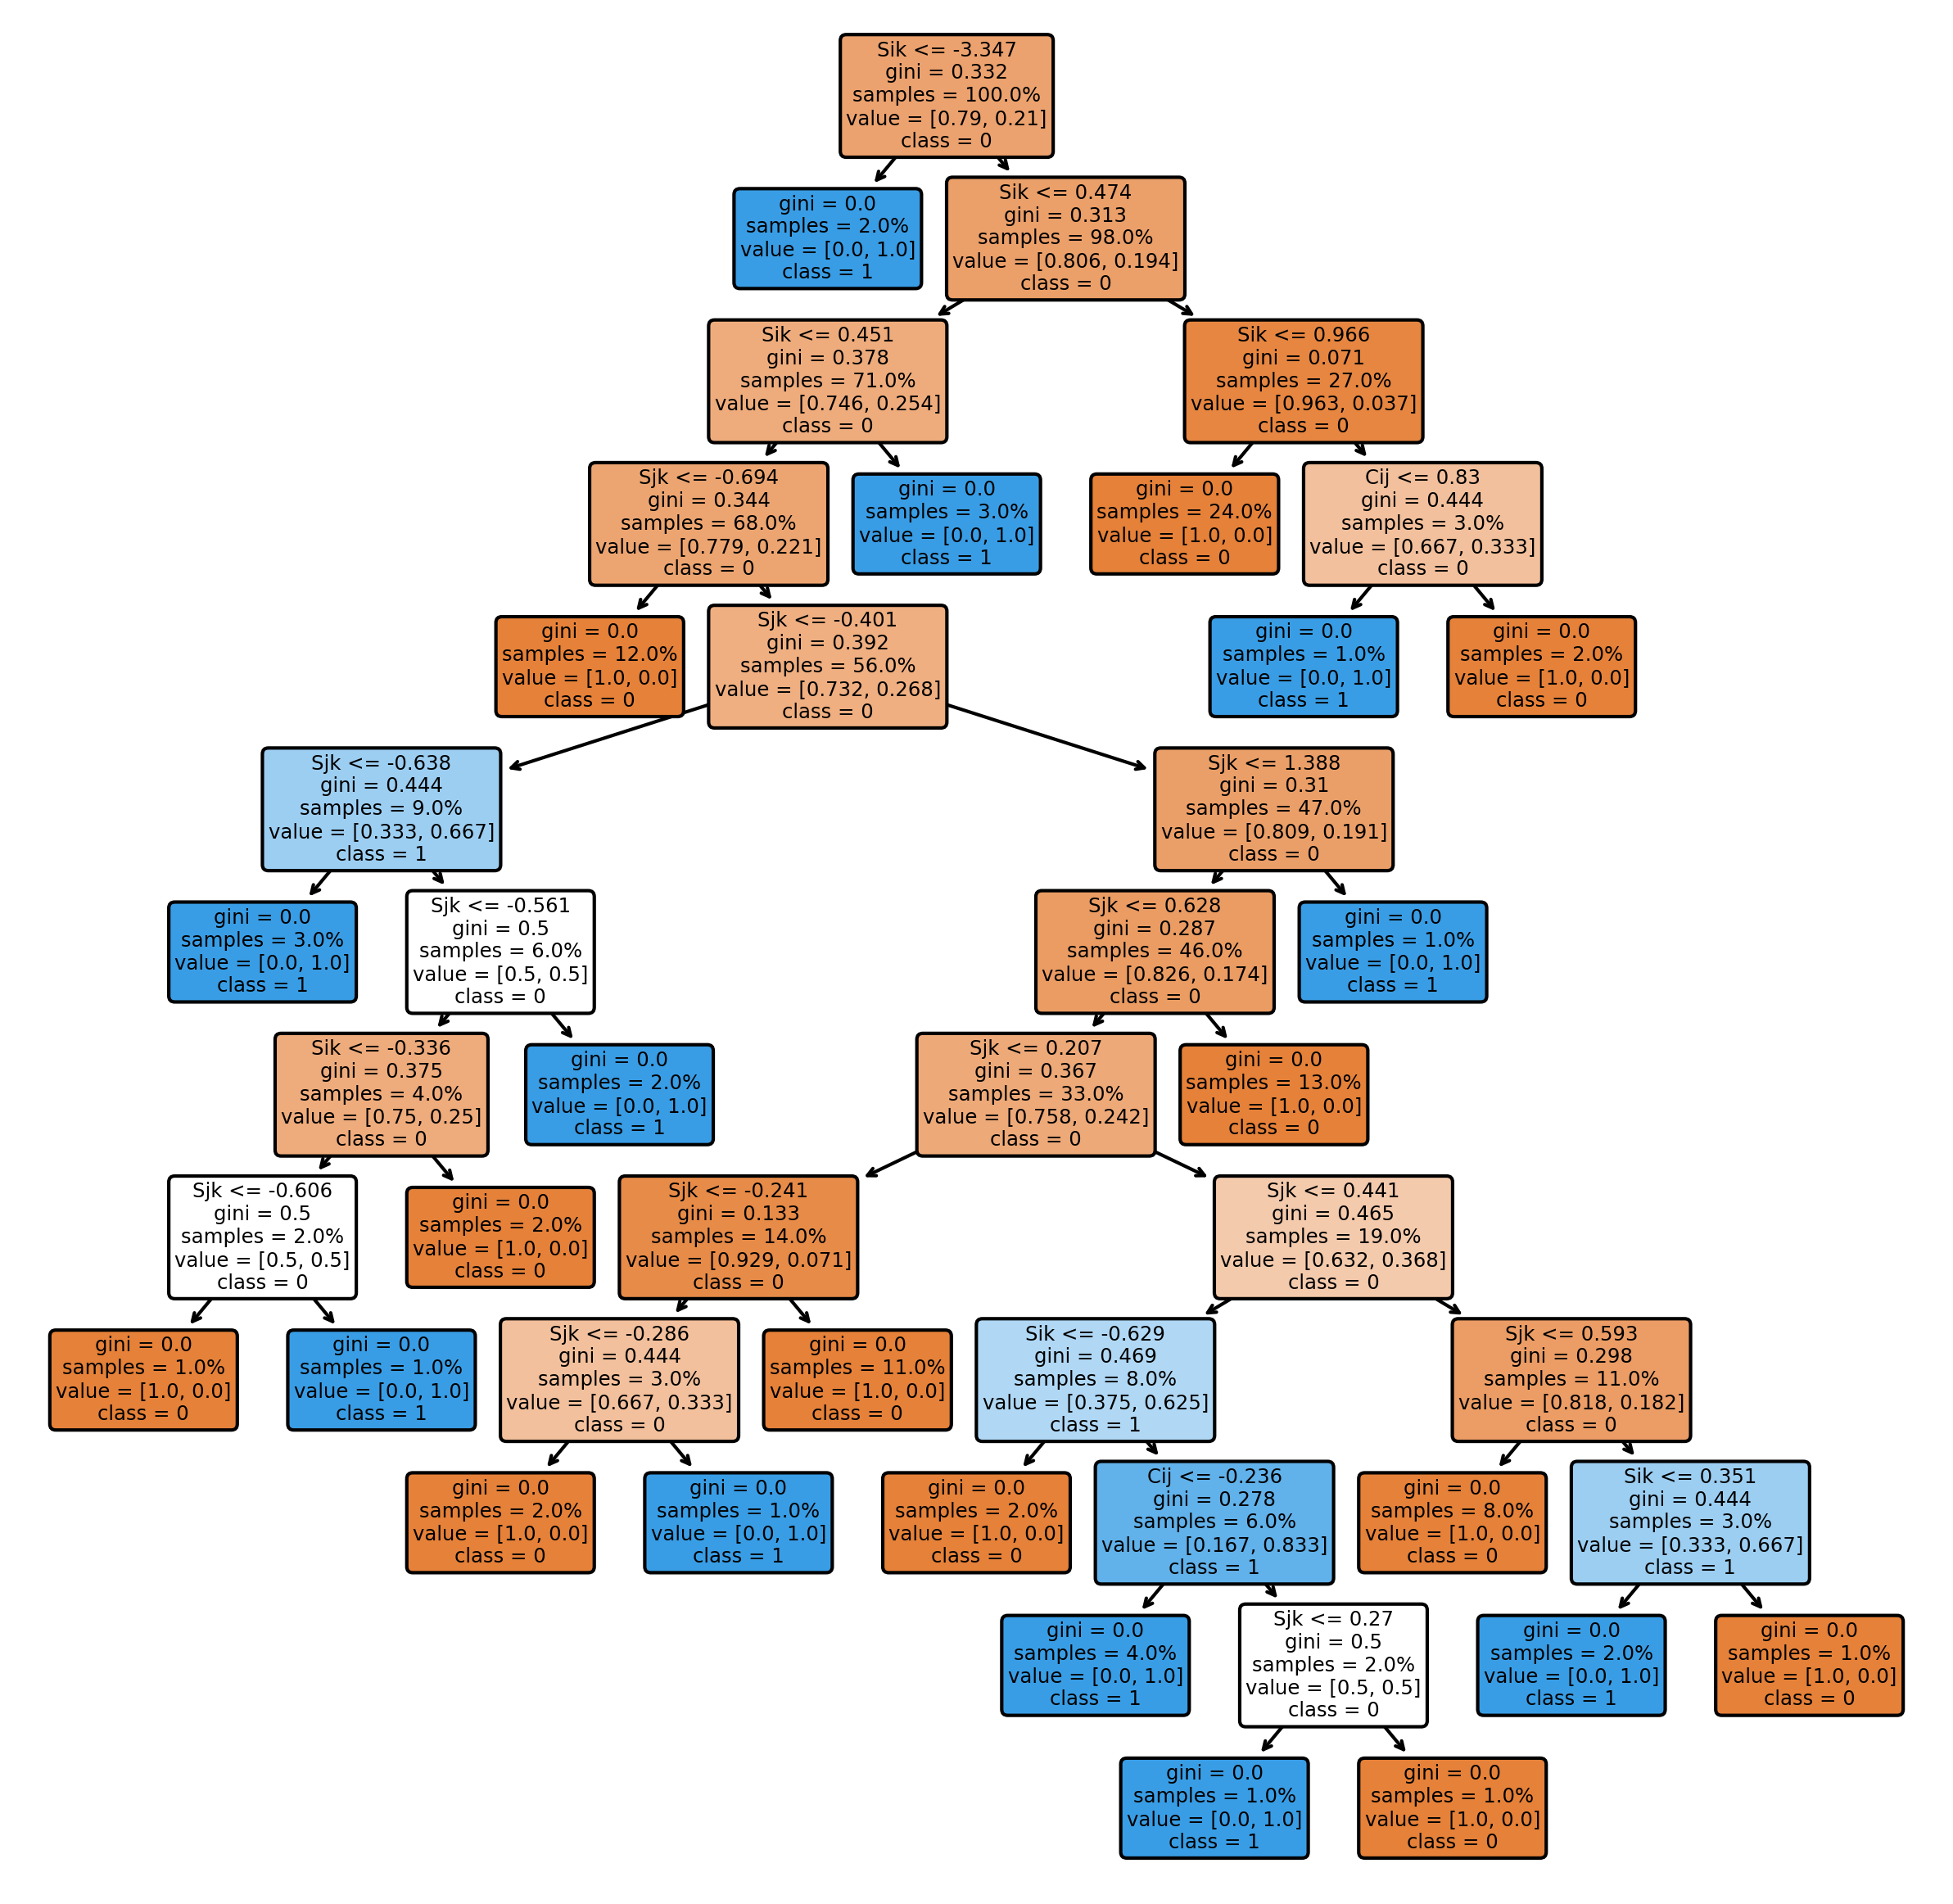

In [104]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), dpi=300)
tree.plot_tree(clf, ax=ax, feature_names=L, class_names=['0', '1'], filled=True, proportion=True, rounded=True);

# Visualization

In [285]:
dfC, dfS, Z = getDistanceAndSensitivityData(df_drug_sensitivity_GDSC2, ['pearson', 'spearman', 'cosine', 'kendall'][1])

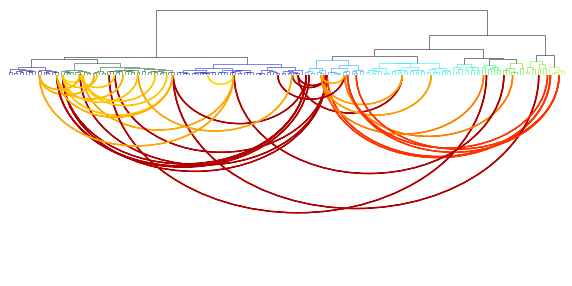

In [286]:
plotDendrogramWithKnownPairs(Z, dfC, se_drug_synergy_Narayan.reset_index('MODEL').index.unique())

In [268]:
# dfC, dfS, Z = getDistanceAndSensitivityData('Both', 'cosine')

# cf = []
# for i in range(100):
#     clf = runForTissueT('Bladder', dfC, dfS, dfTas_synergy, dfTas_no_synergy.sample(n=10**4))
#     cf.append(clf.coef_.tolist()[0] + [clf.intercept_[0]])
#     print(i, end=' ')
# print()
# df = pd.DataFrame(cf)
# df = pd.concat([df.mean(), df.apply(np.median), df.std()], axis=1).T
# df.columns = ['T_ijk', 'C_ij', 'S_ki', 'S_kj', 'intercept']
# df.index = ['avg', 'med', 'std']
# print(df)
# useQu = 'med'
# clf.coef_ = df.loc[useQu].values[None, :-1]
# clf.intercept_ = df.loc[useQu].values[None, -1]

res = runForTissueT('Breast', dfC, dfS, dfTas_synergy, dfTas_no_synergy.sample(n=10**4), df_outData=dfTas_no_synergy, clf=clf)
res.shape

(7955275, 6)

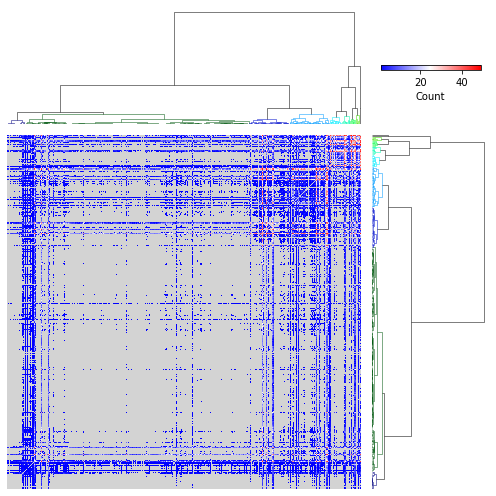

In [278]:
plotH2(dfC, Z, res.loc[res.p>=0.9].index.droplevel(-1).values)

(442, 52) 195364


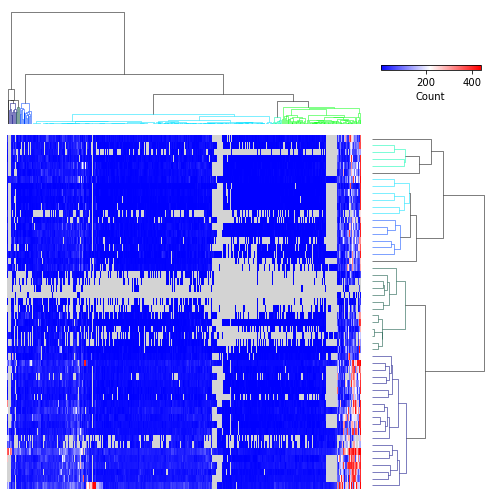

In [284]:
plotH3(dfC, Z, res.loc[res.p>=0.9].index.droplevel(-1).values)

(52463, 52)
(200, 52)


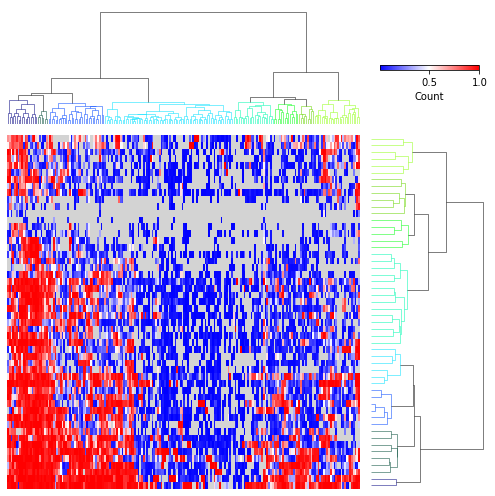

In [290]:
plotH4(dfC, Z, res.loc[res.p>=0.9].index.droplevel(-1).values)